In [1]:
# This document contains the implementation of SVM, Decision Tree and MLP
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import gymnasium as gym
from gym import spaces
import os
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import datasets, svm, metrics
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

Dataset source

https://archive.ics.uci.edu/dataset/222/bank+marketing

https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset

<h3>Column descriptions</h3>

age: Age

job: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

education: (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

default: has credit in default?

balance: average yearly balance

housing: has housing loan?

loan: has personal loan?

contact: contact communication type (categorical: 'cellular','telephone')

day_of_week: last contact day of the week

month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)

previous: number of contacts performed before this campaign and for this client

poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

y: has the client subscribed a term deposit?

# FUNCTIONS

All functions used in this project are in this section

In [2]:
#Read dataset, check for null and duplicates
def read_dataset(dataset):
    
    data = pd.read_csv(dataset)
    nrow = len(data.index)
    ncol = len(data.columns)

    print("The dataset contains", format(nrow, ",d"), "rows and", ncol, "columns.")
    
    #Check for null values
    if ((data.isna().sum()).sum()) > 0:
        print("There are null items in the dataset")
    else:
        print("There are no null items in the dataset")
        
    #Check for duplicates

    if (data.duplicated().sum()) > 0:
        print("There are duplicates in the dataset")
    else:
        print("There are no duplicates in the dataset")
        
    return data



#Function to categorize data into numeric and categorical
def categorize_data(data):
    
    numeric=[]
    categorical=[]
    numeric_dtypes = ["int64", "int32", "float64", "float32"]

    for i in range (len(data.columns)):
        if data[data.columns[i]].dtype in numeric_dtypes:
            numeric.append(data.columns[i])
        else:
            categorical.append(data.columns[i])
            
    return numeric, categorical

    
#Function to check for outliers using interquartile range
#source: https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule#:~:text=A%20commonly%20used%20rule%20says,3%20%2B%201.5%20%E2%8B%85%20IQR%20%E2%80%8D%20.def outliers_check(data, numeric):
    outliers_sum =[]

    for col in (numeric):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 10 * IQR)) | (data[col] > (Q3 + 10 * IQR))
        print(col, "", outliers.sum())
        outliers_sum.append(outliers.sum())

    return outliers.sum()


#function to remove duplicates
def remove_duplicates(data):
    duplicated_sum = data.duplicated().sum()
    if duplicated_sum == 0:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        return data
    else:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        data = data[~data.duplicated()]
        print("Duplicated rows have been removed")
        return data

    
#function to remove outliers    
def remove_outliers(data, numeric):
    
    for col in (numeric):
        median_value = np.median(data[col])
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 10 * IQR)) | (data[col] > (Q3 + 10 * IQR))
        #print(col, "", outliers.sum())
        data.loc[outliers, col] = median_value
    return data


# remove special characters from columns
def remove_spec_chars(data, categorical_cols):
    for col in categorical_cols:
        data[col] = data[col].str.replace(r'\W+', '').str.strip() #replaces special characters with white sapaces and removes the white spaces
    return data



def replace_unknown(data, categorical_cols):
    for col in categorical_cols:
        if "unknown" in data[col].values:
            #source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html
            mode = data[col].mode()[0]
            data[col] = data[col].replace("unknown", mode)
    return data


#one hot encoding
def oneHotEncoding(data, categorical, drop_first):

    data_final = pd.get_dummies(data, columns=categorical, drop_first=drop_first)

    return data_final

# EDA

In [3]:
data = read_dataset("bank.csv") #read dataset

The dataset contains 11,162 rows and 17 columns.
There are no null items in the dataset
There are no duplicates in the dataset


In [4]:
pd.set_option('display.max_columns', None)

(data).head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [6]:
#Summary statistics of the dataset
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [7]:
#Class imbalance
data['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [8]:
#Categorize data into numeric and categorical
numeric_cols, categorical_cols = categorize_data(data)

print(f"{len(numeric_cols)} numeric columns and {len(categorical_cols)} categorical columns")

7 numeric columns and 10 categorical columns


# Visualisations

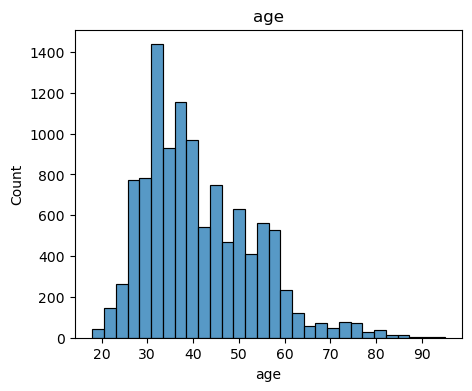

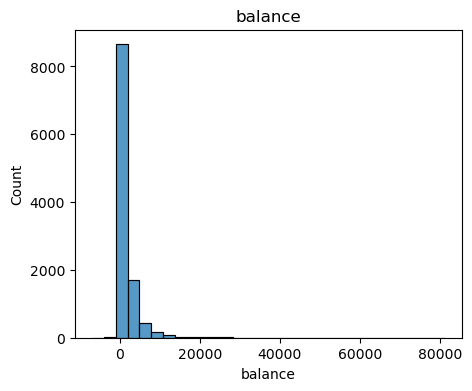

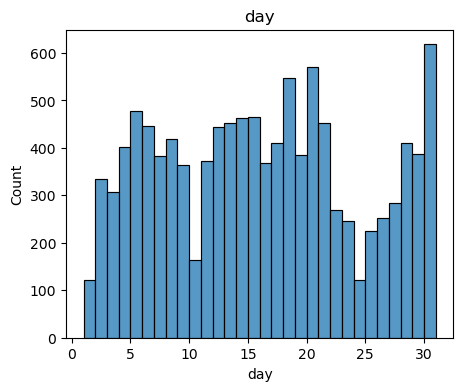

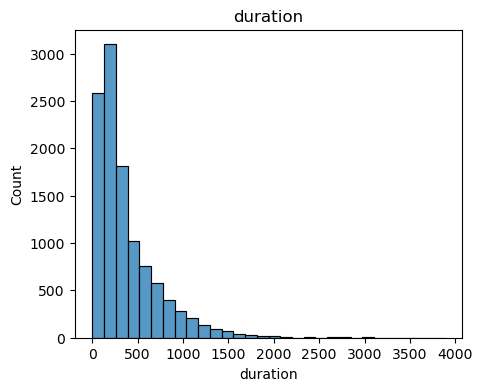

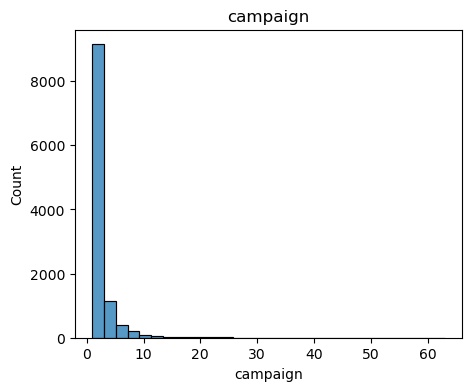

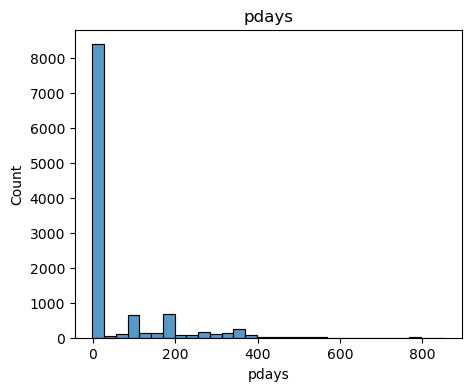

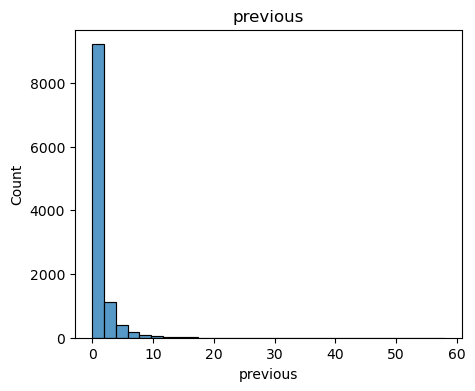

In [9]:
#Check distributions of numeric columns
for i in range (len(numeric_cols)):
    plt.figure(figsize=(5,4))
    sns.histplot(data[numeric_cols[i]], bins=30)
    plt.title(numeric_cols[i])

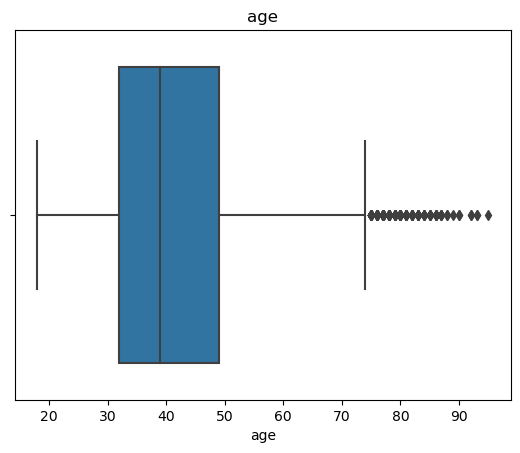

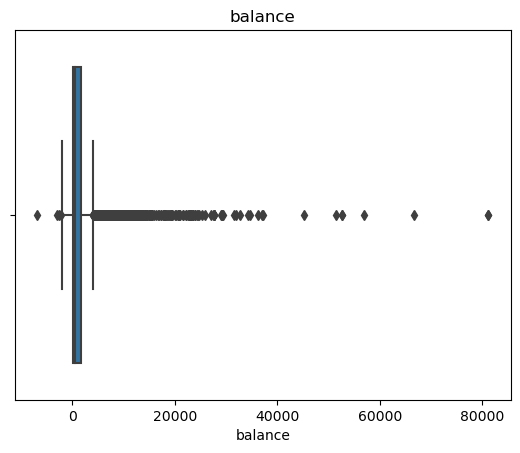

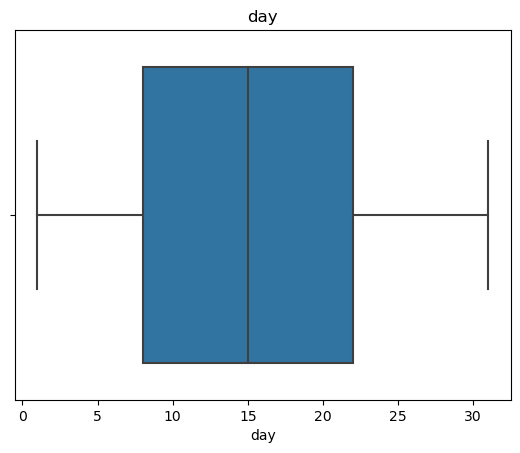

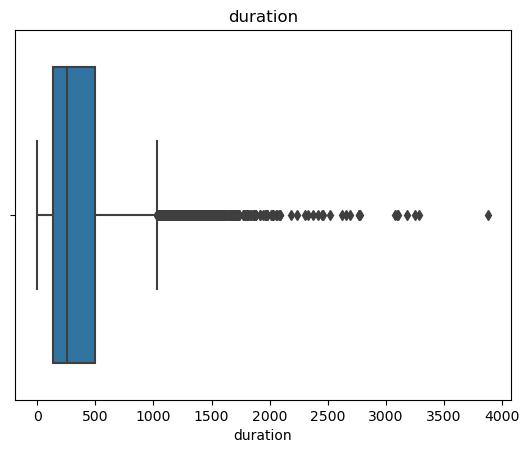

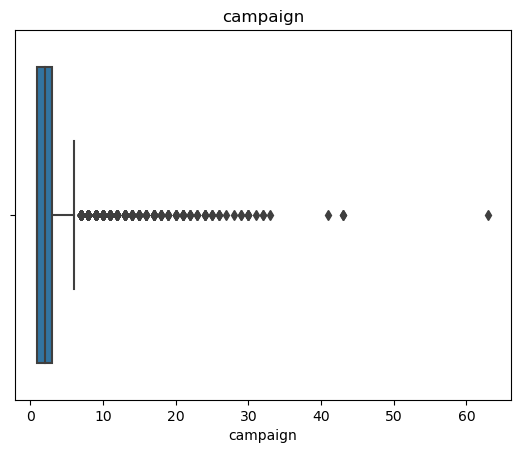

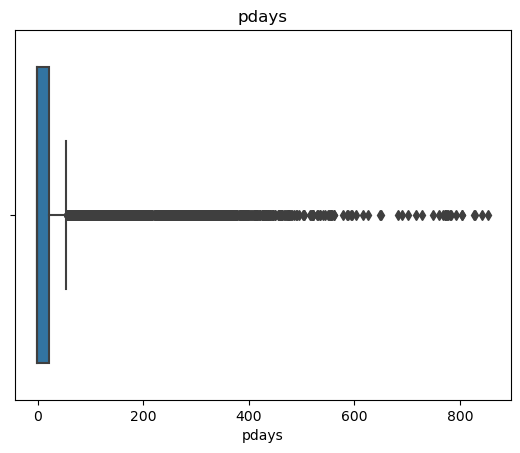

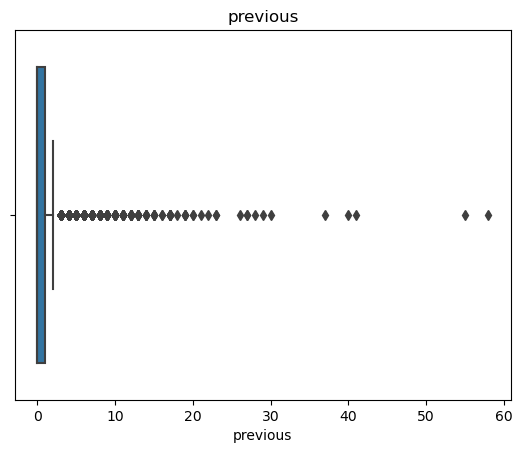

In [10]:
#Box plots for numeric columns
for i in range (len(numeric_cols)):
    plt.figure()
    plt.title(numeric_cols[i])
    sns.boxplot(x=data[numeric_cols[i]], data=data)

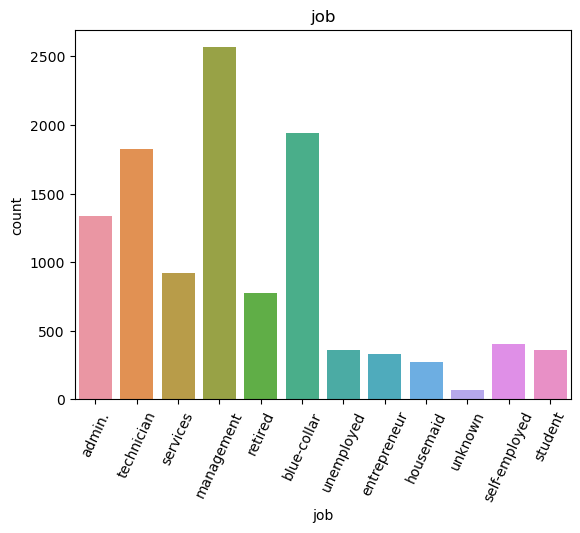

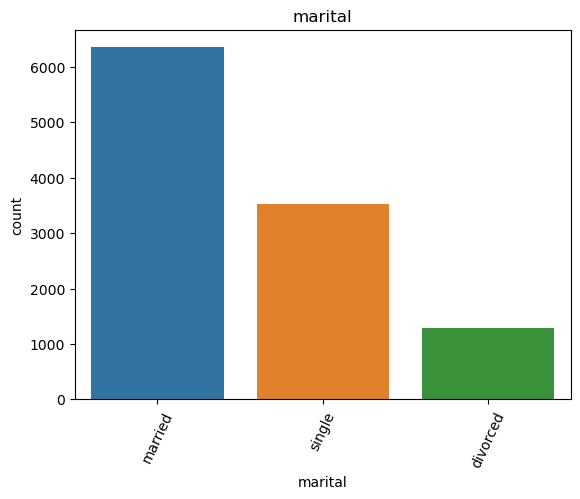

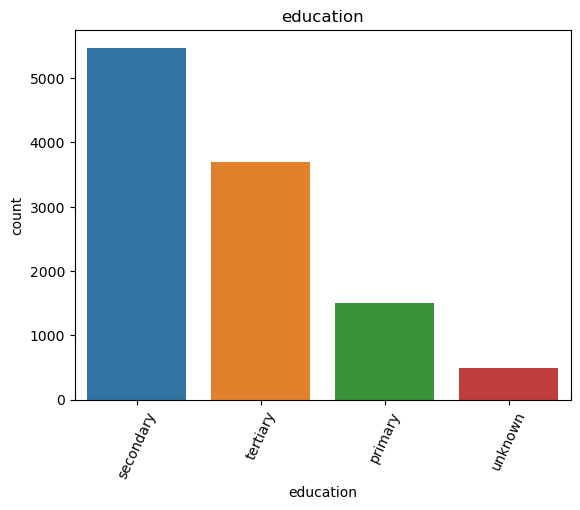

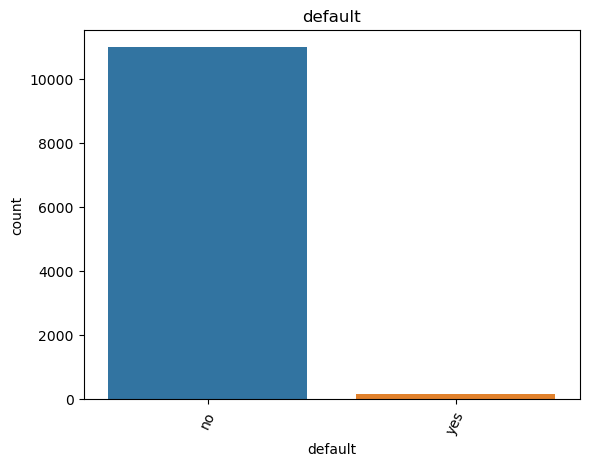

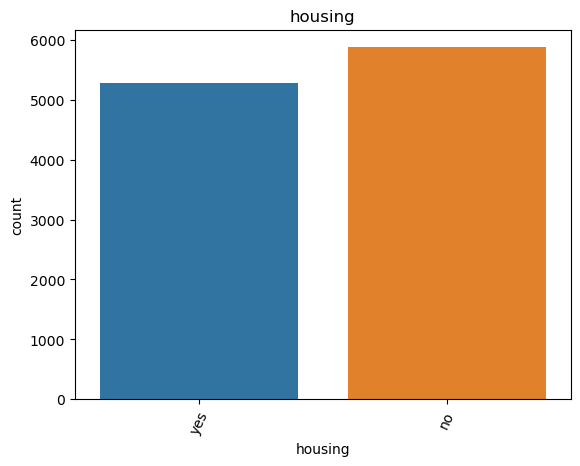

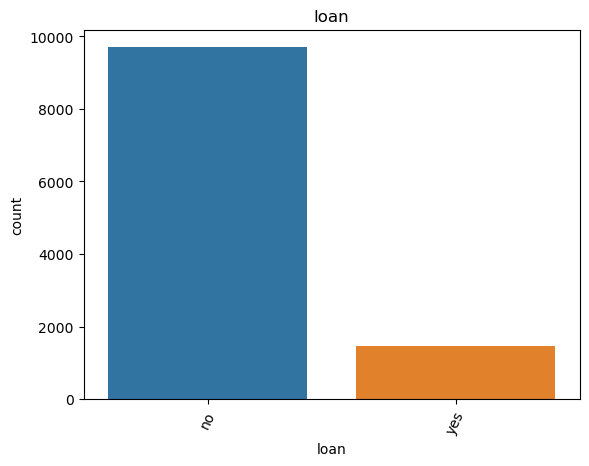

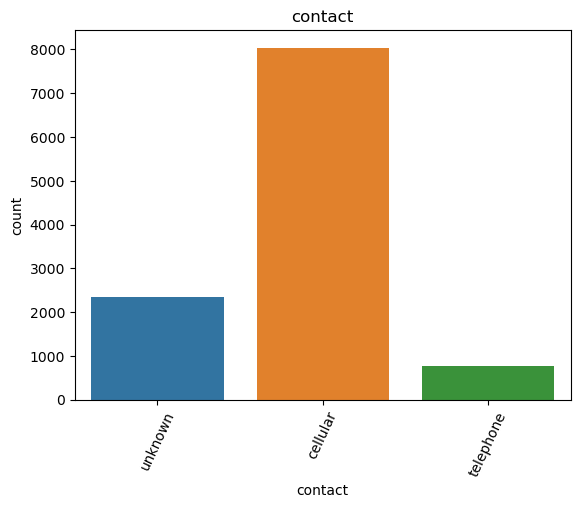

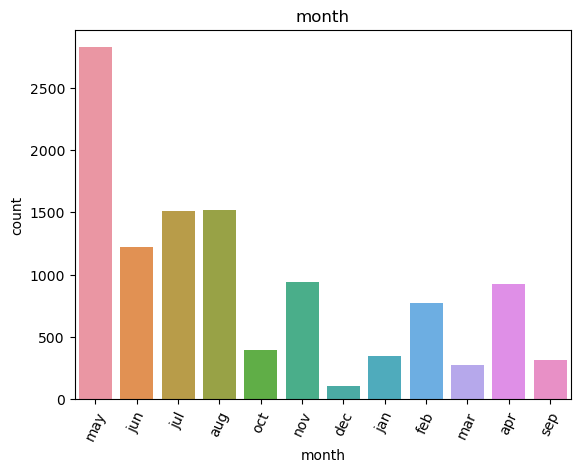

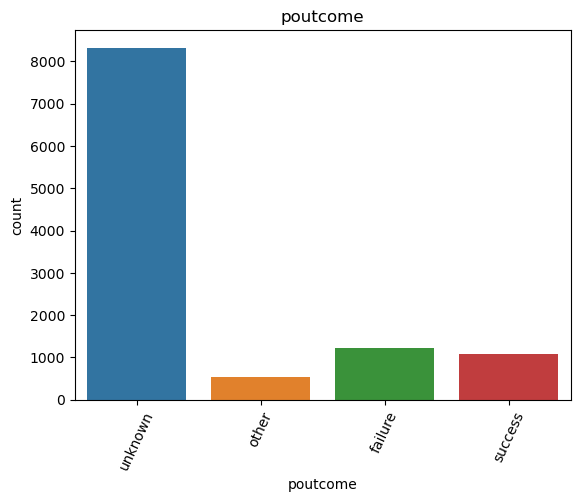

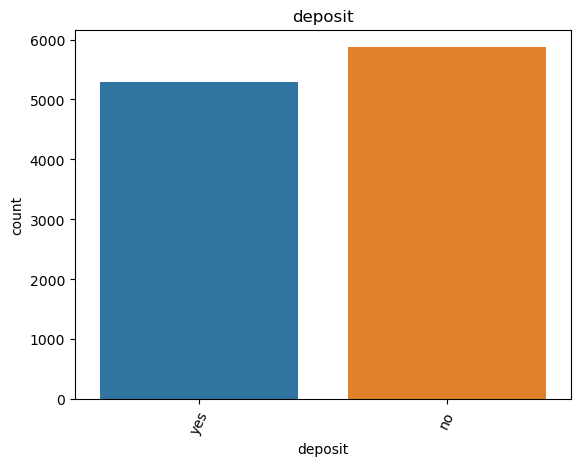

In [11]:
#Bar plots for categorical columns
for i in range (len(categorical_cols)):
    plt.figure()
    plt.title(categorical_cols[i])
    sns.countplot(x=data[categorical_cols[i]], data=data)
    plt.xticks(rotation=65) 

In [12]:
#Check for outliers
outliers = outliers_check(data, numeric_cols)

age  0
balance  74
day  0
duration  0
campaign  27
pdays  917
previous  73


# Correlation Analysis

C:\Users\amych\AppData\Local\Temp\ipykernel_14492\3699474598.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


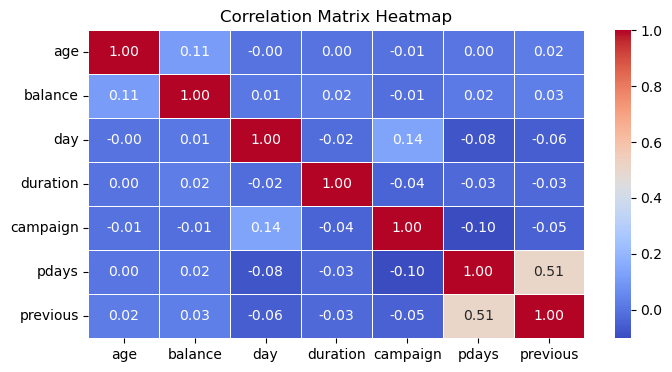

In [13]:
correlation_matrix = data.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Preprocessing

In [14]:
#remove outliers
removed_outliers=remove_outliers(data, numeric_cols)
(removed_outliers)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [15]:
removed_special_chars = remove_spec_chars(removed_outliers, categorical_cols) #remove special characters

removed_special_chars

C:\Users\amych\AppData\Local\Temp\ipykernel_14492\2659610715.py:89: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'\W+', '').str.strip() #replaces special characters with white sapaces and removes the white spaces


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,bluecollar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [16]:
#replace unknown with mode

removed_unknown = replace_unknown(removed_special_chars, categorical_cols)

removed_unknown

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin,married,secondary,no,2343,yes,no,cellular,5,may,1042,1,-1,0,unknown,yes
1,56,admin,married,secondary,no,45,no,no,cellular,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,cellular,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,cellular,5,may,579,1,-1,0,unknown,yes
4,54,admin,married,tertiary,no,184,no,no,cellular,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,bluecollar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,cellular,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [17]:
#drop "poutcocme column"
categorical_cols.remove('poutcome')

dropped_column = removed_unknown.drop(columns=["poutcome"])

dropped_column

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,deposit
0,59,admin,married,secondary,no,2343,yes,no,cellular,5,may,1042,1,-1,0,yes
1,56,admin,married,secondary,no,45,no,no,cellular,5,may,1467,1,-1,0,yes
2,41,technician,married,secondary,no,1270,yes,no,cellular,5,may,1389,1,-1,0,yes
3,55,services,married,secondary,no,2476,yes,no,cellular,5,may,579,1,-1,0,yes
4,54,admin,married,tertiary,no,184,no,no,cellular,5,may,673,2,-1,0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,bluecollar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,no
11158,39,services,married,secondary,no,733,no,no,cellular,16,jun,83,4,-1,0,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,no


# One Hot Encoding

In [18]:
#One hot encoding

data_encoded = oneHotEncoding(dropped_column, categorical_cols, True)

data_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,job_bluecollar,job_entrepreneur,job_housemaid,job_management,job_retired,job_selfemployed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,deposit_yes
0,59,2343,5,1042,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,56,45,5,1467,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,41,1270,5,1389,1,-1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,55,2476,5,579,1,-1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,54,184,5,673,2,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [19]:
data_encoded.shape

(11162, 37)

In [20]:
#Randomise the dataset

data_randomized = data_encoded.sample(frac=1, random_state=42)

#All features except the target are assigned to 'X'
#categorical_cols.remove('deposit')
X = data_encoded.drop("deposit_yes", axis=1)

#Target feature is assigned to 'Y'
Y = data_encoded["deposit_yes"]

X.head()

,age,balance,day,duration,campaign,pdays,previous,job_bluecollar,job_entrepreneur,job_housemaid,job_management,job_retired,job_selfemployed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,59,2343,5,1042,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,56,45,5,1467,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,41,1270,5,1389,1,-1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,55,2476,5,579,1,-1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,54,184,5,673,2,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [21]:
#split into train and test

x, xtest, y, ytest = train_test_split(X, Y, test_size=0.2, random_state=None)
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.3, random_state=None)

# Dataset Scaling

In [22]:
#Scaling the data

scaler = StandardScaler()
xtrain[numeric_cols] = scaler.fit_transform(xtrain[numeric_cols])
xtest[numeric_cols] = scaler.transform(xtest[numeric_cols])
xval[numeric_cols] = scaler.transform(xval[numeric_cols])


xtrain.shape

(6250, 36)

# Dimensionality Reduction Using Principal Component Analysis

In [23]:
#PCA

pca = PCA(34) #Initialize PCA with the desired number of features (components). 2 features are removed making 34


xtrain_pca = pca.fit_transform(xtrain)

xtest_pca = pca.fit_transform(xtest)

xval_pca = pca.fit_transform(xval)

#pca.explained_variance_ratio_

# Modelling

## Decision Tree

In [24]:
#list to contain models, names, data
DT_models = []
DT_name = []
x_val_list = []
x_test_list = []

In [25]:
hyperparameter
ccp_alpha = 0.0001
txt = "ccp_alpha: 0.0001"

In [26]:
#DecsionTree model - dataset with no PCA

#Initialize the decision tree classifier
clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)

DT_models.append(clf)
DT_name.append(f"(No PCA): Decision Tree {txt}")

x_val_list.append(xval)
x_test_list.append(xtest)

#Fit the classifier to the training data
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0001)

In [27]:
#DecsionTree model - dataset with PCA

#Initialize the decision tree classifier
clf_pca = DecisionTreeClassifier(ccp_alpha=ccp_alpha)

DT_models.append(clf_pca)
DT_name.append(f"(PCA): Decision Tree {txt}")

x_val_list.append(xval_pca)
x_test_list.append(xtest_pca)

# Fit the classifier to the training data
clf_pca.fit(xtrain_pca, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0001)

In [32]:
#prediction function
def predict(models, names, x_list, Y, eval_type):
    
    print(f"\033[1mEvaluating {eval_type} data\033[0m \n")
    
    fpr_list, tpr_list, roc_auc_list = [], [], []
    
    for model, name, X in zip(models, names, x_list):
        print(f"\033[1mEvaluating {name}...\033[0m")
        y_pred = model.predict(X)
        accuracy = accuracy_score(Y, y_pred) #accuracy
        report = classification_report(Y, y_pred) #classification report
        print(f"{name} Accuracy:", accuracy)
        
        
        conf_matrix = confusion_matrix(Y, y_pred) #confusion matrix
        
        #plot confusion matrix
        plt.figure(figsize=(3, 2))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        print(f"{name} Classification report:\n", report)

    
        y_prob = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(Y, y_prob) #ROC
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        
        roc_auc = auc(fpr, tpr)
        #print(f"{name} AUC = {roc_auc}")
        roc_auc_list.append(roc_auc)

    #source: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    cmap = plt.colormaps['tab10']
    colors = cmap.colors[:len(names)]
    
    #Plot ROC
    plt.figure(figsize=(10,5))
    for i, (fpr, tpr, roc_auc, name) in enumerate(zip(fpr_list, tpr_list, roc_auc_list, names)):
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) MLP Dataset 3')
    plt.legend(loc='lower right')
    plt.show()

Evaluating decision tree validation data 

Evaluating (No PCA): Decision Tree ccp_alpha: 0.0001...
(No PCA): Decision Tree ccp_alpha: 0.0001 Accuracy: 0.7618514371033968


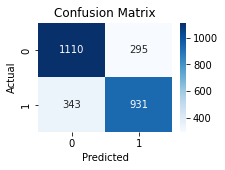

(No PCA): Decision Tree ccp_alpha: 0.0001 Classification report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.78      1405
           1       0.76      0.73      0.74      1274

    accuracy                           0.76      2679
   macro avg       0.76      0.76      0.76      2679
weighted avg       0.76      0.76      0.76      2679

Evaluating (PCA): Decision Tree ccp_alpha: 0.0001...
(PCA): Decision Tree ccp_alpha: 0.0001 Accuracy: 0.6237402015677491


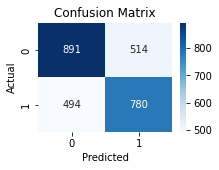

(PCA): Decision Tree ccp_alpha: 0.0001 Classification report:
               precision    recall  f1-score   support

           0       0.64      0.63      0.64      1405
           1       0.60      0.61      0.61      1274

    accuracy                           0.62      2679
   macro avg       0.62      0.62      0.62      2679
weighted avg       0.62      0.62      0.62      2679



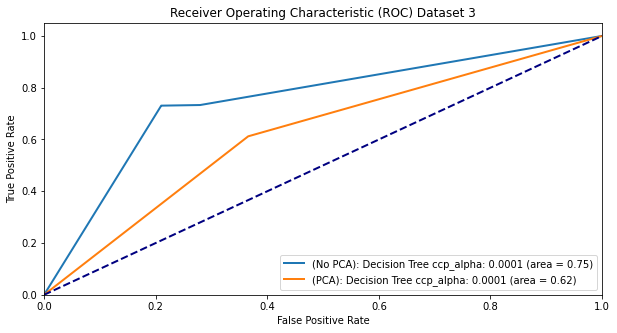

In [29]:
predict(DT_models, DT_name, x_val_list, yval, "decision tree validation")

Evaluating decision tree testing data 

Evaluating (No PCA): Decision Tree ccp_alpha: 0.0001...
(No PCA): Decision Tree ccp_alpha: 0.0001 Accuracy: 0.7586206896551724


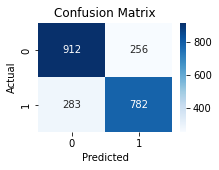

(No PCA): Decision Tree ccp_alpha: 0.0001 Classification report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77      1168
           1       0.75      0.73      0.74      1065

    accuracy                           0.76      2233
   macro avg       0.76      0.76      0.76      2233
weighted avg       0.76      0.76      0.76      2233

Evaluating (PCA): Decision Tree ccp_alpha: 0.0001...
(PCA): Decision Tree ccp_alpha: 0.0001 Accuracy: 0.6180026869682043


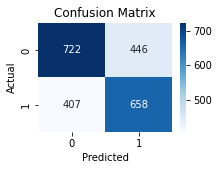

(PCA): Decision Tree ccp_alpha: 0.0001 Classification report:
               precision    recall  f1-score   support

           0       0.64      0.62      0.63      1168
           1       0.60      0.62      0.61      1065

    accuracy                           0.62      2233
   macro avg       0.62      0.62      0.62      2233
weighted avg       0.62      0.62      0.62      2233



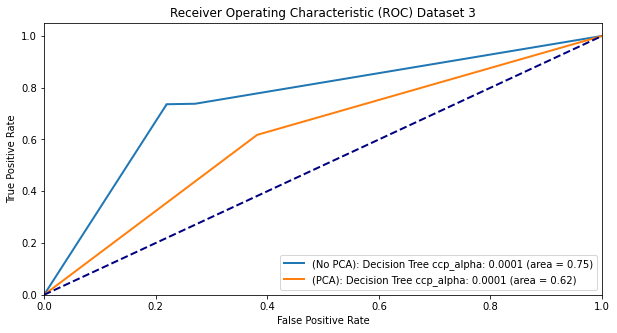

In [30]:
predict(DT_models, DT_name, x_test_list, ytest, "decision tree testing")

### Using the dataset with no PCA for hyperparameter tuning because of its high performance

In [31]:
DT_models = []
DT_name = []
x_val_list = []
x_test_list = []

Accuracy Score on train data:  0.83472


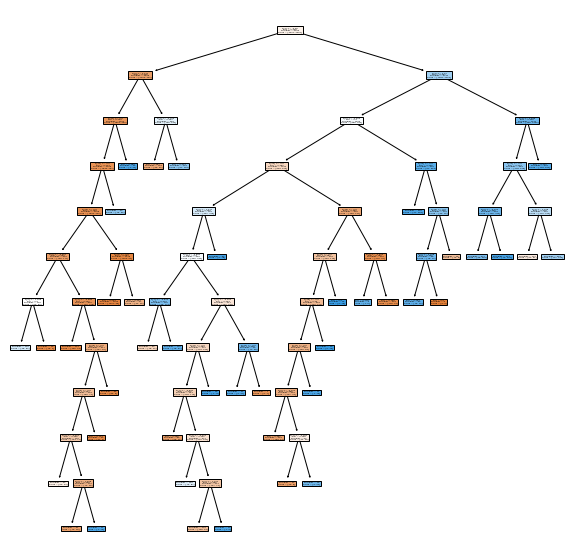

In [32]:
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.001)

clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)

print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain, y_pred=clf.predict(xtrain)))

DT_models.append(clf)
DT_name.append("Dataset (no PCA) ccp_alpha: 0.001")
x_test_list.append(xtest)
x_val_list.append(xval)

#plot decision tree
plt.figure(figsize=(10,10))
plot_tree(clf, filled=True)
plt.show()

Accuracy Score on train data:  0.79696


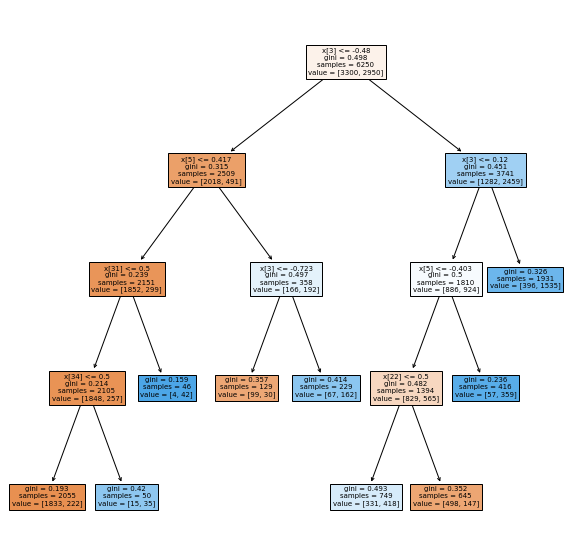

In [33]:
clf2 = DecisionTreeClassifier(random_state=0, ccp_alpha=0.005)

clf2.fit(xtrain, ytrain)

y_pred = clf2.predict(xtest)

print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain, y_pred=clf2.predict(xtrain)))

DT_models.append(clf2)
DT_name.append("Dataset (no PCA) ccp_alpha: 0.005")
x_test_list.append(xtest)
x_val_list.append(xval)

plt.figure(figsize=(10,10))
plot_tree(clf2, filled=True)
plt.show()

Evaluating validation data 

Evaluating Dataset (no PCA) ccp_alpha: 0.001...
Dataset (no PCA) ccp_alpha: 0.001 Accuracy: 0.8062709966405375


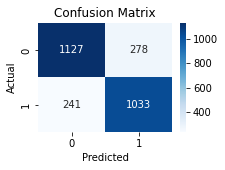

Dataset (no PCA) ccp_alpha: 0.001 Classification report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      1405
           1       0.79      0.81      0.80      1274

    accuracy                           0.81      2679
   macro avg       0.81      0.81      0.81      2679
weighted avg       0.81      0.81      0.81      2679

Evaluating Dataset (no PCA) ccp_alpha: 0.005...
Dataset (no PCA) ccp_alpha: 0.005 Accuracy: 0.7846211272863008


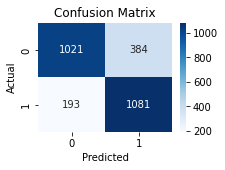

Dataset (no PCA) ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78      1405
           1       0.74      0.85      0.79      1274

    accuracy                           0.78      2679
   macro avg       0.79      0.79      0.78      2679
weighted avg       0.79      0.78      0.78      2679



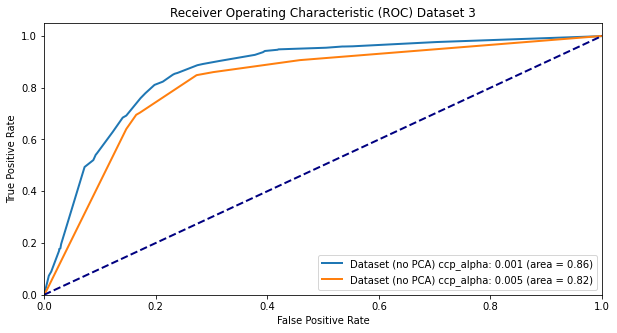

In [34]:
predict(DT_models, DT_name, x_val_list, yval, "validation")

Evaluating testing data 

Evaluating Dataset (no PCA) ccp_alpha: 0.001...
Dataset (no PCA) ccp_alpha: 0.001 Accuracy: 0.8038513210927004


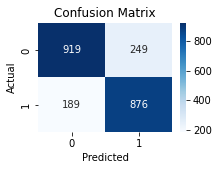

Dataset (no PCA) ccp_alpha: 0.001 Classification report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1168
           1       0.78      0.82      0.80      1065

    accuracy                           0.80      2233
   macro avg       0.80      0.80      0.80      2233
weighted avg       0.81      0.80      0.80      2233

Evaluating Dataset (no PCA) ccp_alpha: 0.005...
Dataset (no PCA) ccp_alpha: 0.005 Accuracy: 0.7787729511867443


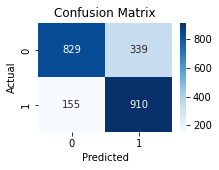

Dataset (no PCA) ccp_alpha: 0.005 Classification report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      1168
           1       0.73      0.85      0.79      1065

    accuracy                           0.78      2233
   macro avg       0.79      0.78      0.78      2233
weighted avg       0.79      0.78      0.78      2233



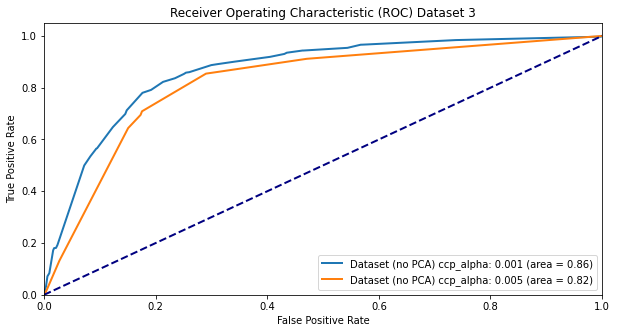

In [35]:
predict(DT_models, DT_name, x_test_list, ytest, "testing")

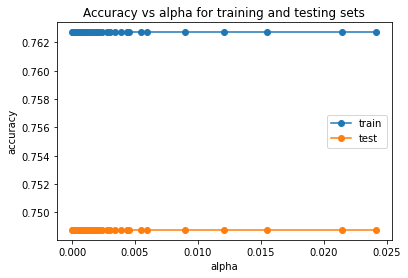

In [36]:
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.001)
path = clf.cost_complexity_pruning_path(xtrain, ytrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.015)
    clf.fit(xtrain, ytrain)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Calculate training and testing scores for each classifier
train_scores = [clf.score(xtrain, ytrain) for clf in clfs]
test_scores = [clf.score(xtest, ytest) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

## Support Vector Machine (SVM)

In [37]:
SVM_models = []
SVM_name = []
x_val_list = []
x_test_list = []

In [38]:
gamma = 0.05
txt = "gamma: 0.05"

In [39]:
#SVM model - dataset with no PCA

#Initialize the SVM classifier
SVM = svm.SVC(probability=True, random_state=42)
SVM_models.append(SVM)
SVM_name.append(f"(No PCA) SVM {txt}")
x_val_list.append(xval)
x_test_list.append(xtest)

#Fit the classifier to the training data
SVM.fit(xtrain, ytrain)

SVC(probability=True, random_state=42)

In [40]:
#SVM model - dataset with PCA

#Initialize the SVM classifier
SVM_pca = svm.SVC(probability=True, random_state=42)
SVM_models.append(SVM_pca)
SVM_name.append(f"(PCA) SVM {txt}")
x_val_list.append(xval_pca)
x_test_list.append(xtest_pca)

#Fit the classifier to the training data
SVM_pca.fit(xtrain_pca, ytrain)

SVC(probability=True, random_state=42)

Evaluating SVM validation data 

Evaluating (No PCA) SVM gamma: 0.05...
(No PCA) SVM gamma: 0.05 Accuracy: 0.8271743187756626


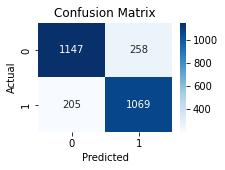

(No PCA) SVM gamma: 0.05 Classification report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1405
           1       0.81      0.84      0.82      1274

    accuracy                           0.83      2679
   macro avg       0.83      0.83      0.83      2679
weighted avg       0.83      0.83      0.83      2679

Evaluating (PCA) SVM gamma: 0.05...
(PCA) SVM gamma: 0.05 Accuracy: 0.706233669279582


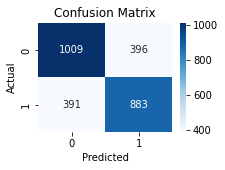

(PCA) SVM gamma: 0.05 Classification report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72      1405
           1       0.69      0.69      0.69      1274

    accuracy                           0.71      2679
   macro avg       0.71      0.71      0.71      2679
weighted avg       0.71      0.71      0.71      2679



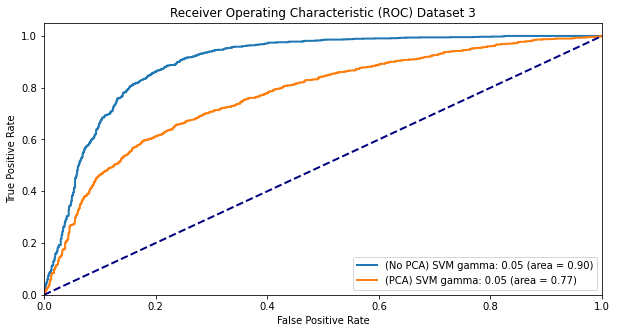

In [41]:
predict(SVM_models, SVM_name, x_val_list, yval, "SVM validation")

Evaluating SVM testing data 

Evaluating (No PCA) SVM gamma: 0.05...
(No PCA) SVM gamma: 0.05 Accuracy: 0.8280340349305867


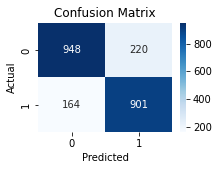

(No PCA) SVM gamma: 0.05 Classification report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1168
           1       0.80      0.85      0.82      1065

    accuracy                           0.83      2233
   macro avg       0.83      0.83      0.83      2233
weighted avg       0.83      0.83      0.83      2233

Evaluating (PCA) SVM gamma: 0.05...
(PCA) SVM gamma: 0.05 Accuracy: 0.6538289296909987


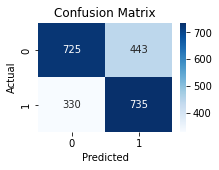

(PCA) SVM gamma: 0.05 Classification report:
               precision    recall  f1-score   support

           0       0.69      0.62      0.65      1168
           1       0.62      0.69      0.66      1065

    accuracy                           0.65      2233
   macro avg       0.66      0.66      0.65      2233
weighted avg       0.66      0.65      0.65      2233



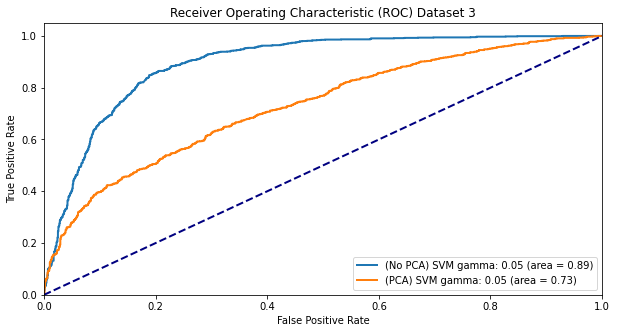

In [42]:
predict(SVM_models, SVM_name, x_test_list, ytest, "SVM testing")

# Cross Validation on Best Performing Datasets

## Multi Layer Perceptron

In [24]:
from sklearn.neural_network import MLPClassifier

MLP_models = []
MLP_name = []
x_val_list = []
x_test_list = []

In [25]:
#Initialize the MLP classifier
MLP = MLPClassifier(random_state=42)

#Append the MLP model to the corresponding lists
MLP_models.append(MLP)
MLP_name.append(f"(No PCA) MLP")
x_val_list.append(xval)
x_test_list.append(xtest)

#Fit the classifier to the training data
MLP.fit(xtrain, ytrain)

C:\Users\amych\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [26]:
#Initialize the MLP classifier
MLP_pca = MLPClassifier(random_state=42)

#Append the MLP model to the corresponding lists
MLP_models.append(MLP_pca)
MLP_name.append(f"(PCA) MLP")
x_val_list.append(xval_pca)
x_test_list.append(xtest_pca)

#Fit the classifier to the training data
MLP_pca.fit(xtrain_pca, ytrain)

C:\Users\amych\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

Evaluating MLP validation data 

Evaluating (No PCA) MLP...
(No PCA) MLP Accuracy: 0.8152295632698768


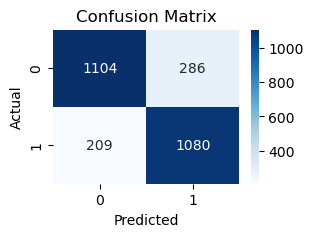

(No PCA) MLP Classification report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.82      1390
           1       0.79      0.84      0.81      1289

    accuracy                           0.82      2679
   macro avg       0.82      0.82      0.82      2679
weighted avg       0.82      0.82      0.82      2679

Evaluating (PCA) MLP...
(PCA) MLP Accuracy: 0.7416946621873833


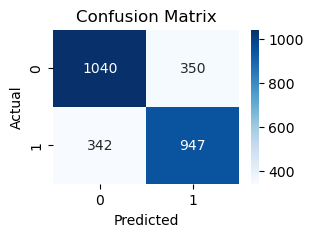

(PCA) MLP Classification report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75      1390
           1       0.73      0.73      0.73      1289

    accuracy                           0.74      2679
   macro avg       0.74      0.74      0.74      2679
weighted avg       0.74      0.74      0.74      2679



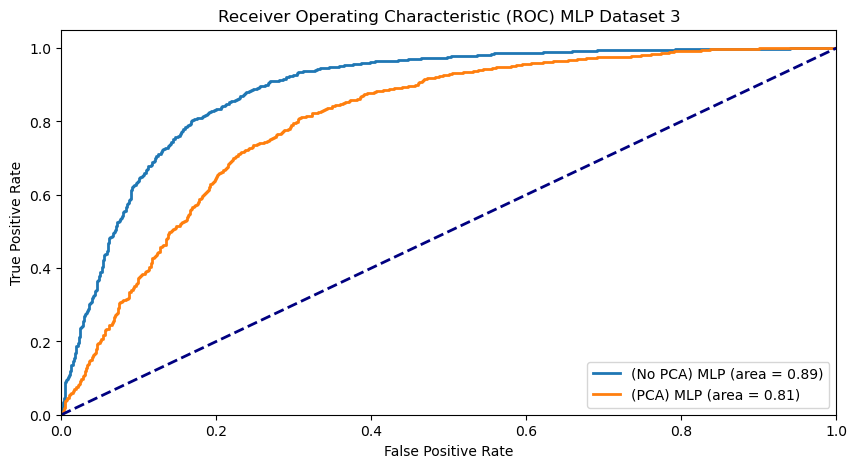

In [28]:
#Predict and evaluate the MLP models on the validation set
predict(MLP_models, MLP_name, x_val_list, yval, "MLP validation")

Evaluating MLP testing data 

Evaluating (No PCA) MLP...
(No PCA) MLP Accuracy: 0.8356471115091805


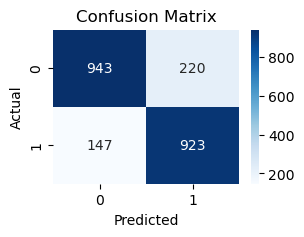

(No PCA) MLP Classification report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1163
           1       0.81      0.86      0.83      1070

    accuracy                           0.84      2233
   macro avg       0.84      0.84      0.84      2233
weighted avg       0.84      0.84      0.84      2233

Evaluating (PCA) MLP...
(PCA) MLP Accuracy: 0.7111509180474698


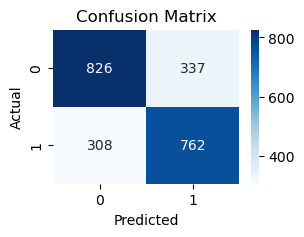

(PCA) MLP Classification report:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72      1163
           1       0.69      0.71      0.70      1070

    accuracy                           0.71      2233
   macro avg       0.71      0.71      0.71      2233
weighted avg       0.71      0.71      0.71      2233



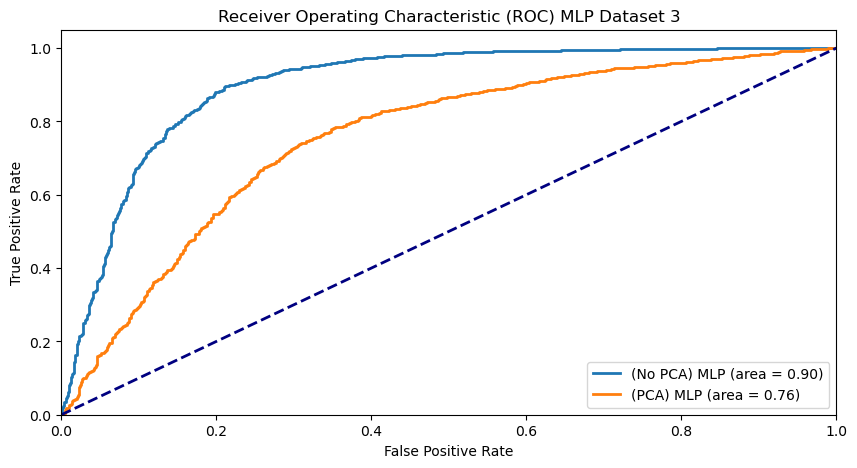

In [33]:
predict(MLP_models, MLP_name, x_test_list, ytest, "MLP testing")

Decision Tree: 0.811680 (0.012881)
SVM: 0.839520 (0.012060)


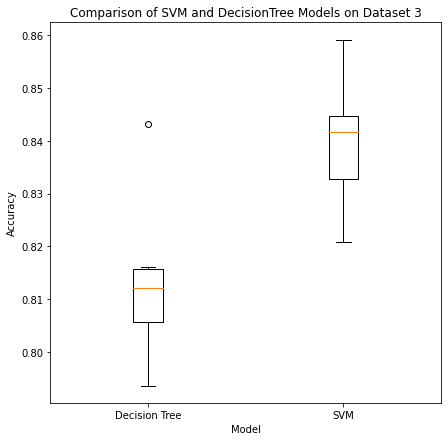

In [43]:
# Evaluate each model in turn
models = [
    ('Decision Tree', DecisionTreeClassifier(ccp_alpha=0.002)),
    ('SVM', svm.SVC(probability=True, random_state=42, gamma=0.1)),
    ('MLP', MLPClassifier(random_state=42))
]


models_list = []
x_val_list = []
x_test_list = []

results = []
names = []
for name, model in models:
    models_list.append(model)
    x_test_list.append(xtest)
    kfold = StratifiedKFold(n_splits=10, random_state=None)
    cv_results = cross_val_score(model, xtrain, ytrain, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.figure(figsize=(7,7))
plt.boxplot(results, labels=names)
plt.title('Comparison of on Dataset 3')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()